### Anna Stankiewicz

Celem projektu jest analiza danych dotyczących udaru mózgu, znajdujących się w pliku `healthcare-dataset-stroke-data.csv`. 


# 1. Importy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, auc

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 2. Wczytanie danych

In [2]:
data_stroke = pd.read_csv("healthcare-dataset-stroke-data.csv", comment="#", sep=',')
data_stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# 3. Zrozumienie danych
##### Dane dotyczące udaru mózgu.
**id** -numer pacjenta

**gender** - płeć

**age** - wiek w latach

**hypertension** - nadciśnienie (0/1) 
 
**heart_disease** - choroba serca (0/1)

**ever_married** - czy pacjent był zonaty/zamężny (yes/no)

**Residence_type** - miejsce zamieszkania - urban - miejski, rural - wiejski

**work_type** - typ pracy - 5 rodzajów - self-employed(samozatrudniony), Govt_job - praca rządowa

**avg_glucose_level** -średni poziom glukozy, nie ma jednostek i skali??? (wg. 	eAG (mg/dL) - może być do 300
    Normal range: less than 114 mg/dL
    Prediabetes range: greater than 114 mg/dL and less than 140 mg/dL
    Diabetes range: greater than 140 mg/dL
    
**bmi** - bmi

**smoking_status** -formerly smoked - wcześniej palący

**stroke** - zmienna celu

In [3]:
type(data_stroke)
data_stroke.shape
data_stroke.columns
data_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
#INFORMACJE O DANYCH
#rózne typy danych - trzeba pozmieniać
#BMI - barkuje 201 kolumn - ?? - trzeba zrobić coś na NaNami
#zmienić hypertension, heart_disease, do ever_maried, work_type, residence_type, smiking_status zobiektowych na kategoryczne


In [5]:
#pozmieniam zmienne objekt na category - 
#data_stroke.gender = data_stroke.gender.astype('category')
#data_stroke.hypertension = data_stroke.hypertension.astype('category')
#data_stroke.heart_disease = data_stroke.heart_disease.astype('category')
#data_stroke.ever_married = data_stroke.ever_married.astype('category')
#data_stroke.work_type = data_stroke.work_type.astype('category')
#data_stroke.Residence_type = data_stroke.Residence_type.astype('category')
#data_stroke.smoking_status = data_stroke.smoking_status.astype('category')
#data_stroke.stroke = data_stroke.stroke.astype('category')

In [6]:
#usunięcie kolumny ID - nic nie wnosi
data_stroke.drop('id', axis=1, inplace=True)

In [7]:
#szukanie braków danych
data_stroke_nan_index = data_stroke.index[data_stroke.isnull().any(axis=1)]
data_stroke.iloc[data_stroke_nan_index]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
5039,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [8]:
#usuwanie/imputacja braków danych - wszystkich obserwacji 5110 (100%), więc 201 to będzie niecałe 4%, 
#zacznę od usunięcia i zobaczę co dalej będzie
data_stroke.dropna(inplace=True)
data_stroke.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   Residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     4909 non-null   object 
 10  stroke             4909 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 460.2+ KB


In [9]:
#poznaje kolejne kolumny nietypowe
data_stroke.groupby('gender').count()
#gender ma male, female ( w miarę równo rozłożone) i kolumne inne(1 odczyt)

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,,,,,,,,,,
Female,2897,2897,2897,2897,2897,2897,2897,2897,2897,2897
Male,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
Other,1,1,1,1,1,1,1,1,1,1


In [10]:
data_stroke.drop(data_stroke[data_stroke['gender']=='Other'].index, inplace=True)
data_stroke.groupby('gender').count()

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,,,,,,,,,,
Female,2897,2897,2897,2897,2897,2897,2897,2897,2897,2897
Male,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011


In [11]:
data_stroke.groupby('ever_married').count()
#kolumny yes, no(trochę nierówno 1727:3353)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
ever_married,,,,,,,,,,
No,1704,1704,1704,1704,1704,1704,1704,1704,1704,1704
Yes,3204,3204,3204,3204,3204,3204,3204,3204,3204,3204


In [12]:
data_stroke.groupby('work_type').count()
#5 rodzajów - govt job - praca rządowa,

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
work_type,,,,,,,,,,
Govt_job,630,630,630,630,630,630,630,630,630,630
Never_worked,22,22,22,22,22,22,22,22,22,22
Private,2810,2810,2810,2810,2810,2810,2810,2810,2810,2810
Self-employed,775,775,775,775,775,775,775,775,775,775
children,671,671,671,671,671,671,671,671,671,671


In [13]:
data_stroke.groupby('Residence_type').count()
#tylko miejskie i wiejskie(równo ułożone)

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
Residence_type,,,,,,,,,,
Rural,2418,2418,2418,2418,2418,2418,2418,2418,2418,2418
Urban,2490,2490,2490,2490,2490,2490,2490,2490,2490,2490


In [14]:
data_stroke.groupby('smoking_status').count()
#4 rodzaje 

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke
smoking_status,,,,,,,,,,
Unknown,1483,1483,1483,1483,1483,1483,1483,1483,1483,1483
formerly smoked,836,836,836,836,836,836,836,836,836,836
never smoked,1852,1852,1852,1852,1852,1852,1852,1852,1852,1852
smokes,737,737,737,737,737,737,737,737,737,737


In [15]:
data_stroke.groupby('stroke').count()
#zmienna celu
#tu mamy dwa rodzaje - duża nierówność prawie 5000:250

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
stroke,,,,,,,,,,
0,4699,4699,4699,4699,4699,4699,4699,4699,4699,4699
1,209,209,209,209,209,209,209,209,209,209


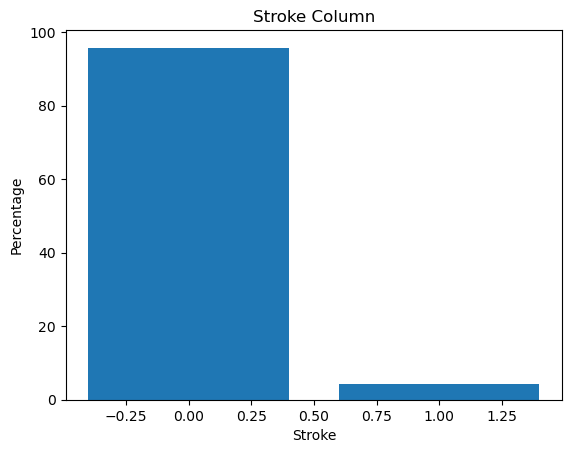

In [17]:
#Przy klasyfikacji jednym z najwazniejszych pytań podczas eksploracyjnej analizy danych 
#jest zbalansowanie zmiennej zaleznej a raczej jego brak. 
#W przypadku niezbalansowanych danych dużo trudniej jest zbudować dobrze działający klasyfikator.

counts = data_stroke['stroke'].value_counts()
percentages = counts / counts.sum() * 100

plt.bar(percentages.index, percentages.values) 
plt.title('Stroke Column')
plt.xlabel('Stroke')
plt.ylabel('Percentage')
plt.show()
#zmienna niezbilansowana - uzyc potem smota, niektóre metody mają(svc) mają balance_classes= True

In [18]:
#badam zmienne numeryczne
data_stroke.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4908.000000,4908.000000,4908.000000,4908.000000,4908.00000,4908.000000
mean,42.868810,0.091891,0.049511,105.297402,28.89456,0.042584
std,22.556128,0.288901,0.216954,44.425550,7.85432,0.201937
min,0.080000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,25.000000,0.000000,0.000000,77.067500,23.50000,0.000000
50%,44.000000,0.000000,0.000000,91.680000,28.10000,0.000000
75%,60.000000,0.000000,0.000000,113.495000,33.10000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.60000,1.000000


# 4. Outliery 
wiek i glukoza wyglądają znośnie, BMI ma dziwne wyniki

poniżej 16 - wygłodzenie
16 - 16.99 - wychudzenie
17 - 18.49 - niedowagę
18.5 - 24.99 - wagę prawidłową
25.0 - 29.9 - nadwagę
30.0 - 34.99 - I stopień otyłości
35.0 - 39.99 - II stopień otyłości
powyżej 40.0 - otyłość skrajną


In [19]:
#Szukam outlierów metodą z_scores
data_stroke_imputed = pd.DataFrame(data_stroke, columns=['age', 'avg_glucose_level', 'bmi'])

means = np.mean(data_stroke_imputed, axis=0)
sds = np.std(data_stroke_imputed, axis=0)
z_scores = np.abs(data_stroke_imputed - means) / sds
outliers = np.where(z_scores > 3)

print(outliers)

(array([  27,   38,   62,   80,   94,  103,  104,  112,  125,  158,  161,
        182,  204,  216,  218,  230,  263,  290,  293,  302,  317,  344,
        388,  423,  498,  506,  517,  591,  616,  624,  659,  666,  704,
        710,  734,  872, 1003, 1009, 1012, 1019, 1053, 1144, 1164, 1235,
       1252, 1311, 1362, 1379, 1449, 1452, 1477, 1482, 1502, 1513, 1543,
       1573, 1797, 1965, 1975, 2019, 2027, 2073, 2093, 2146, 2161, 2180,
       2215, 2324, 2345, 2421, 2431, 2443, 2508, 2568, 2624, 2636, 2685,
       2708, 2781, 2917, 2944, 3087, 3186, 3233, 3235, 3320, 3347, 3426,
       3443, 3443, 3523, 3536, 3602, 3654, 3737, 3758, 3804, 3871, 3976,
       4009, 4029, 4045, 4068, 4167, 4172, 4223, 4262, 4271, 4284, 4289,
       4410, 4521, 4645, 4713, 4716, 4756, 4787, 4837], dtype=int64), array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1,
       2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2,
       2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2

In [20]:
data_stroke_imputed.iloc[outliers[0][outliers[1] == 2]]
data_stroke = data_stroke[data_stroke["bmi"] <= 52] #powyżej 60 to chyba niemożliwe 

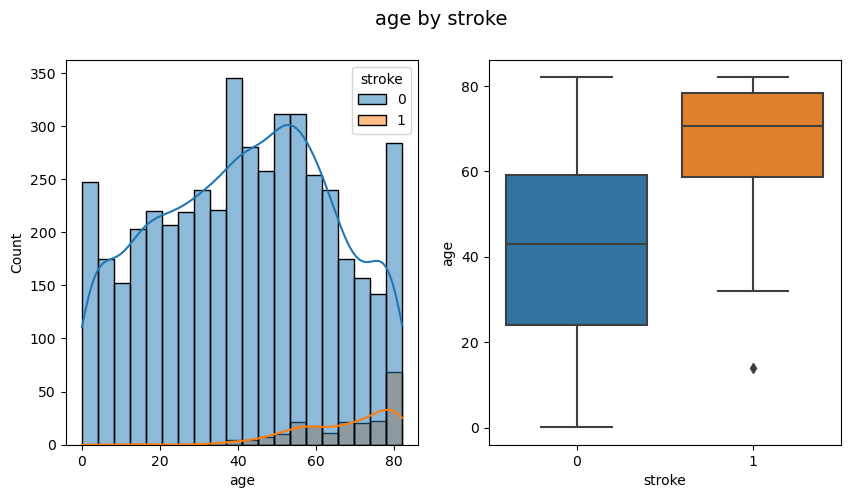

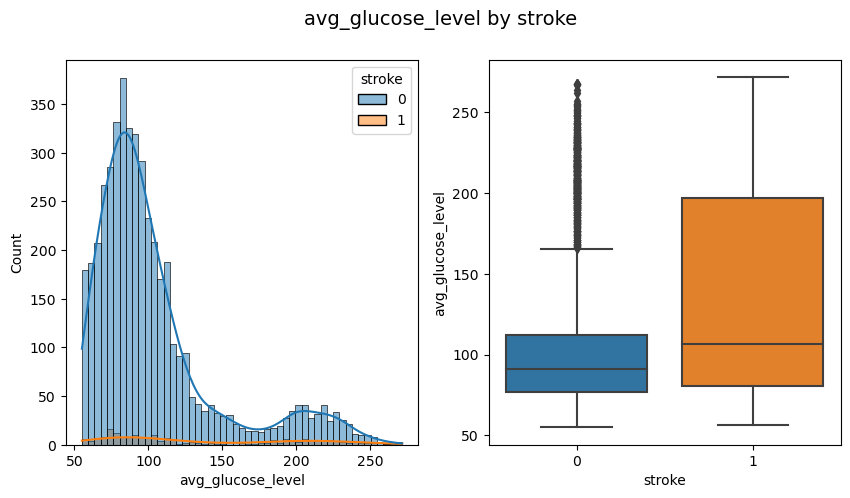

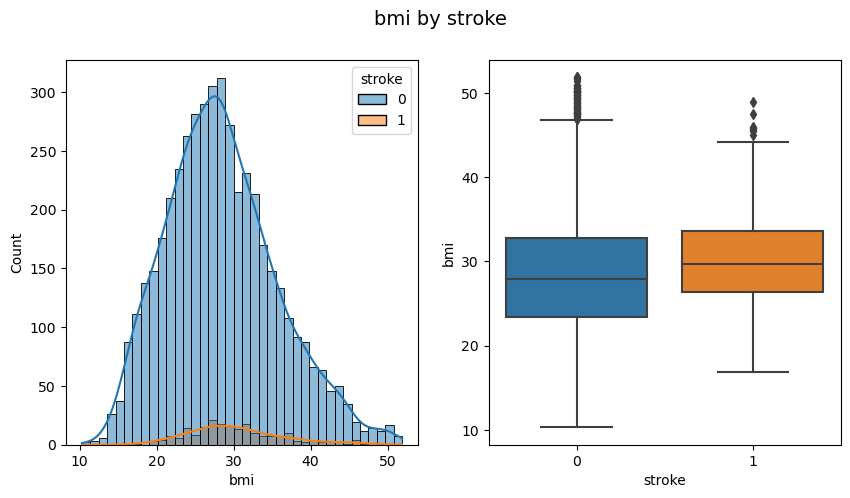

In [21]:
num_cols = ['age', 'avg_glucose_level', 'bmi']

for col in num_cols:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    sns.histplot(data=data_stroke, x=col, hue='stroke', kde=True, ax=ax1)
    sns.boxplot(data=data_stroke, x='stroke', y=col, ax=ax2)
    fig.suptitle(f'{col} by stroke', fontsize=14)
    plt.show()

# 5. Korelacja

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


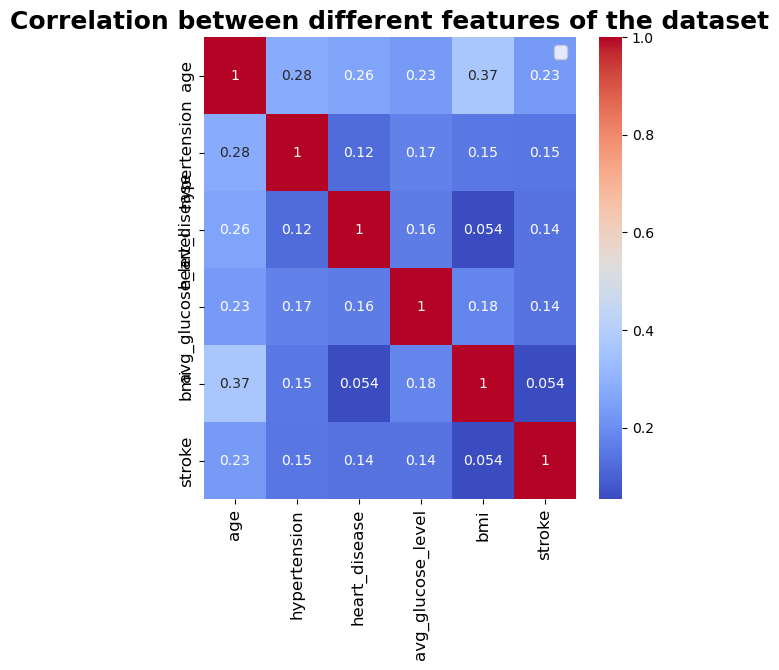

In [26]:
#Sprawdzam ewentualną korelację pomiędzy zmiennymi  numerycznymi
plt.figure(figsize = (6,6))
plt.title("Correlation between different features of the dataset", fontsize = 18, fontweight = 'bold')
sns.heatmap(data_stroke.corr(numeric_only = True), cmap = 'coolwarm', annot = True)
plt.xticks(fontsize=12, rotation = 90)
plt.yticks(fontsize=12, rotation = 90)
plt.legend(fontsize=12)

#korelacji nie ma
#czy da się zbadać korelcję z kategorycznymi???

In [29]:
corr_P = data_stroke.corr("pearson", numeric_only=True)
corr_P.shape

(6, 6)

In [30]:
corr_P

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.276877,0.258206,0.234213,0.366343,0.233633
hypertension,0.276877,1.000000,0.120272,0.174614,0.151030,0.147241
heart_disease,0.258206,0.120272,1.000000,0.158493,0.053848,0.138444
avg_glucose_level,0.234213,0.174614,0.158493,1.000000,0.181625,0.139207
bmi,0.366343,0.151030,0.053848,0.181625,1.000000,0.053592
stroke,0.233633,0.147241,0.138444,0.139207,0.053592,1.000000


In [31]:
corr_P_tri = corr_P.where(np.triu(np.ones(corr_P.shape, dtype=bool), k=1)).stack().sort_values()
corr_P_tri

bmi                stroke               0.053592
heart_disease      bmi                  0.053848
hypertension       heart_disease        0.120272
heart_disease      stroke               0.138444
avg_glucose_level  stroke               0.139207
hypertension       stroke               0.147241
                   bmi                  0.151030
heart_disease      avg_glucose_level    0.158493
hypertension       avg_glucose_level    0.174614
avg_glucose_level  bmi                  0.181625
age                stroke               0.233633
                   avg_glucose_level    0.234213
                   heart_disease        0.258206
                   hypertension         0.276877
                   bmi                  0.366343
dtype: float64

In [33]:
corr_P_tri[abs(corr_P_tri)>0.3]

age  bmi    0.366343
dtype: float64

Nie widzę większej korelacji pomiędzy zmiennymi numerycznymi.


# 6. Wykresy

In [27]:
def generate_plots_and_tables_by_tagret(df: pd.DataFrame, target_column: str = "DefFlag",
                                        numeric_cols: list = [], categorical_cols: list = []) -> None:
    """
    Generate plots of the 'target_column' column with other columns in a pandas dataframe.
    If a column is a string or factor, a bar plot with grouping by 'target_column' will be created.
    If a column is continuous, a histogram, boxplot, and scatter plot with grouping by 'target_column' will be created.
    """
    for column in categorical_cols:
        print(column + ":")
        
        plt.figure(figsize=(8, 6))
            
        counts = df.groupby([column, target_column], group_keys=True).size()
        print(counts)
        counts_norm = counts.groupby(level=0, group_keys=False).apply(lambda x: 100 * x / x.sum())
        counts_norm = counts_norm.reset_index(name='percent')
        sns.barplot(x=column, y='percent', hue=target_column, data=counts_norm)
        plt.title(f"'stroke' vs '{column}'")
        plt.show()
            
    for column in numeric_cols:
        
        plt.figure(figsize=(18, 6))
            
        plt.subplot(1, 2, 1)
        sns.histplot(x=column, hue=target_column, data=df, kde=True)
        plt.title(f"'stroke' vs '{column}' (Histogram)")
            
        plt.subplot(1, 2, 2)
        sns.boxplot(x=target_column, y=column, data=df)
        plt.title(f"'stroke' vs '{column}' (Boxplot)")
            
        plt.tight_layout()
        plt.show()

gender:
gender  stroke
Female  0         2736
        1          119
Male    0         1905
        1           89
dtype: int64


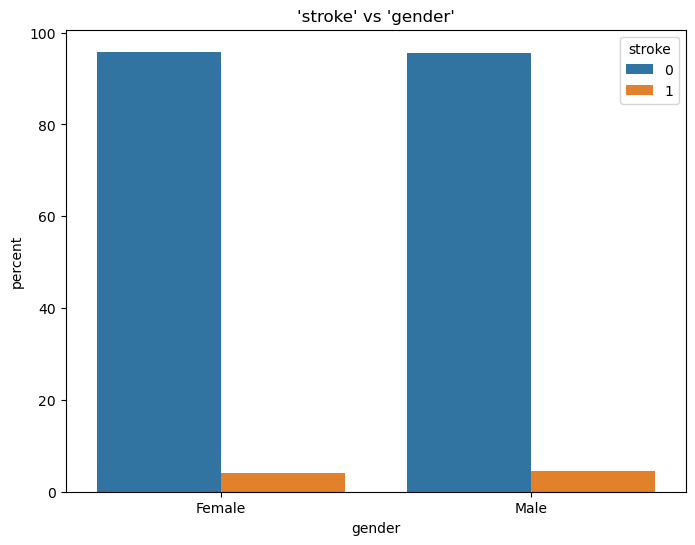

hypertension:
hypertension  stroke
0             0         4266
              1          148
1             0          375
              1           60
dtype: int64


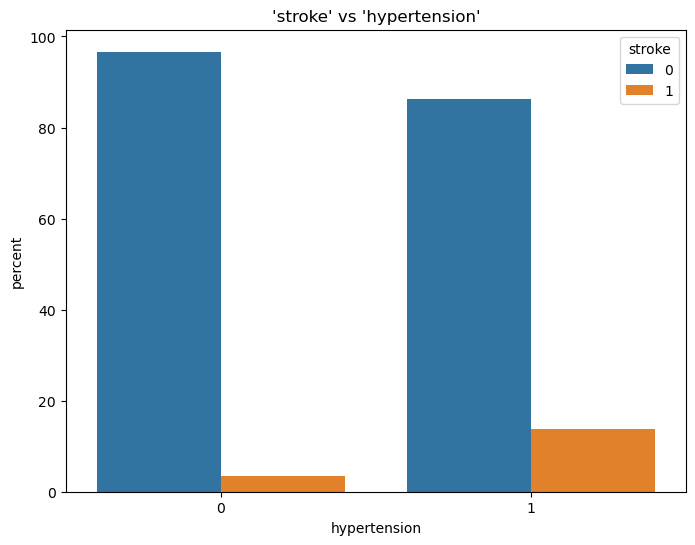

heart_disease:
heart_disease  stroke
0              0         4439
               1          168
1              0          202
               1           40
dtype: int64


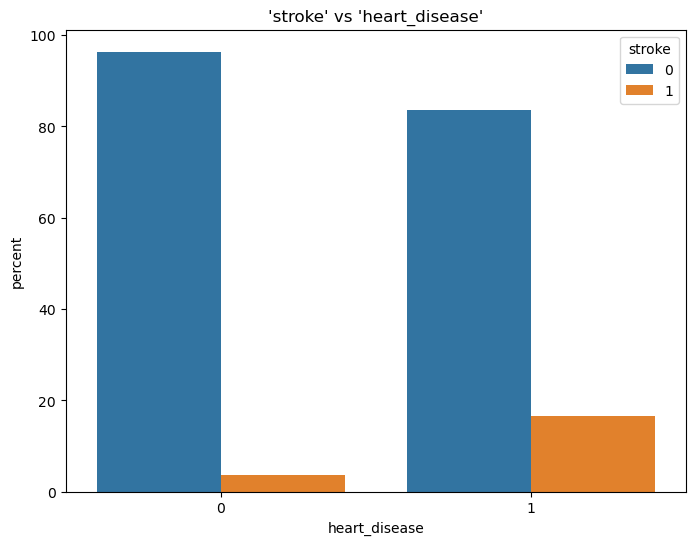

ever_married:
ever_married  stroke
No            0         1669
              1           23
Yes           0         2972
              1          185
dtype: int64


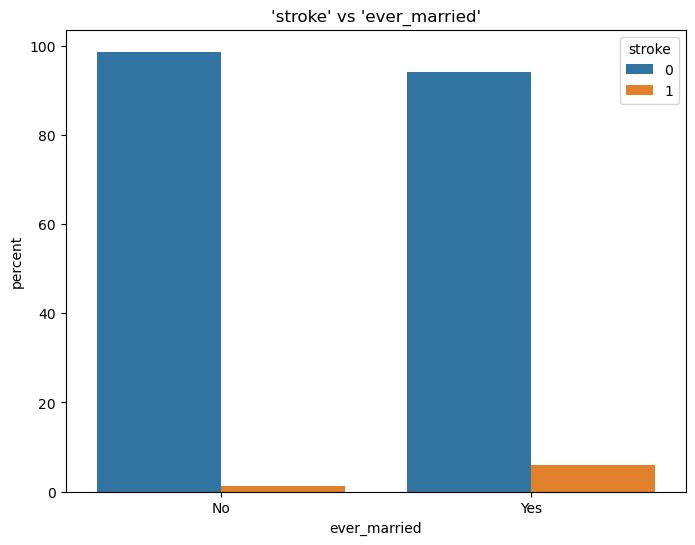

work_type:
work_type      stroke
Govt_job       0          594
               1           28
Never_worked   0           22
Private        0         2641
               1          126
Self-employed  0          714
               1           53
children       0          670
               1            1
dtype: int64


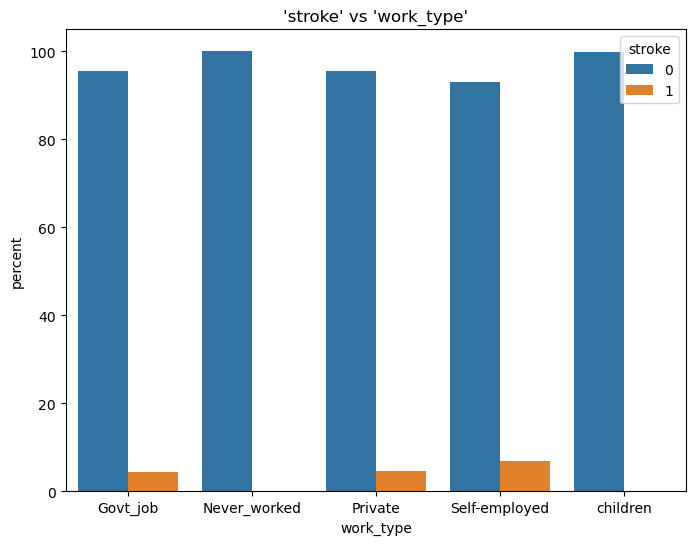

Residence_type:
Residence_type  stroke
Rural           0         2287
                1           99
Urban           0         2354
                1          109
dtype: int64


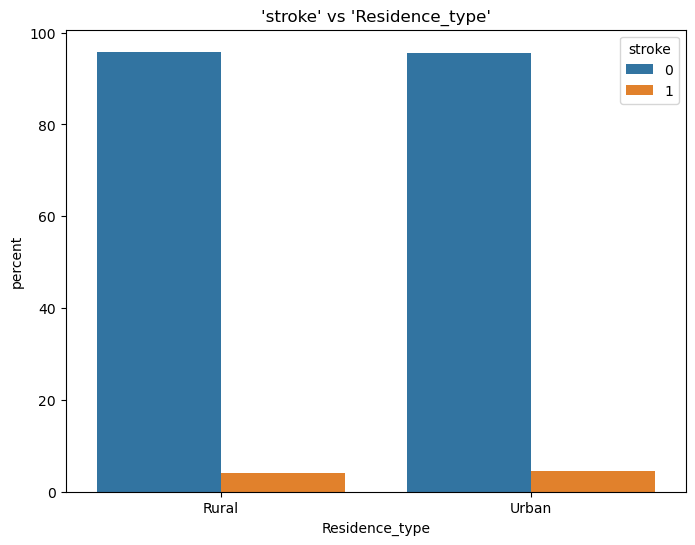

smoking_status:
smoking_status   stroke
Unknown          0         1439
                 1           29
formerly smoked  0          768
                 1           57
never smoked     0         1744
                 1           83
smokes           0          690
                 1           39
dtype: int64


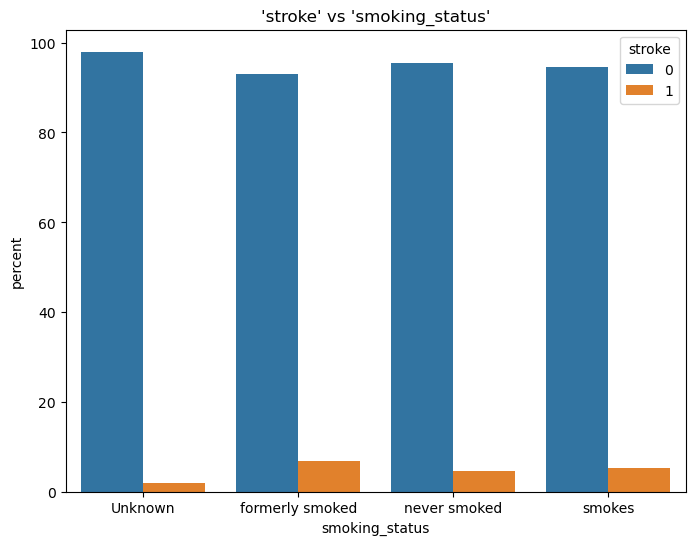

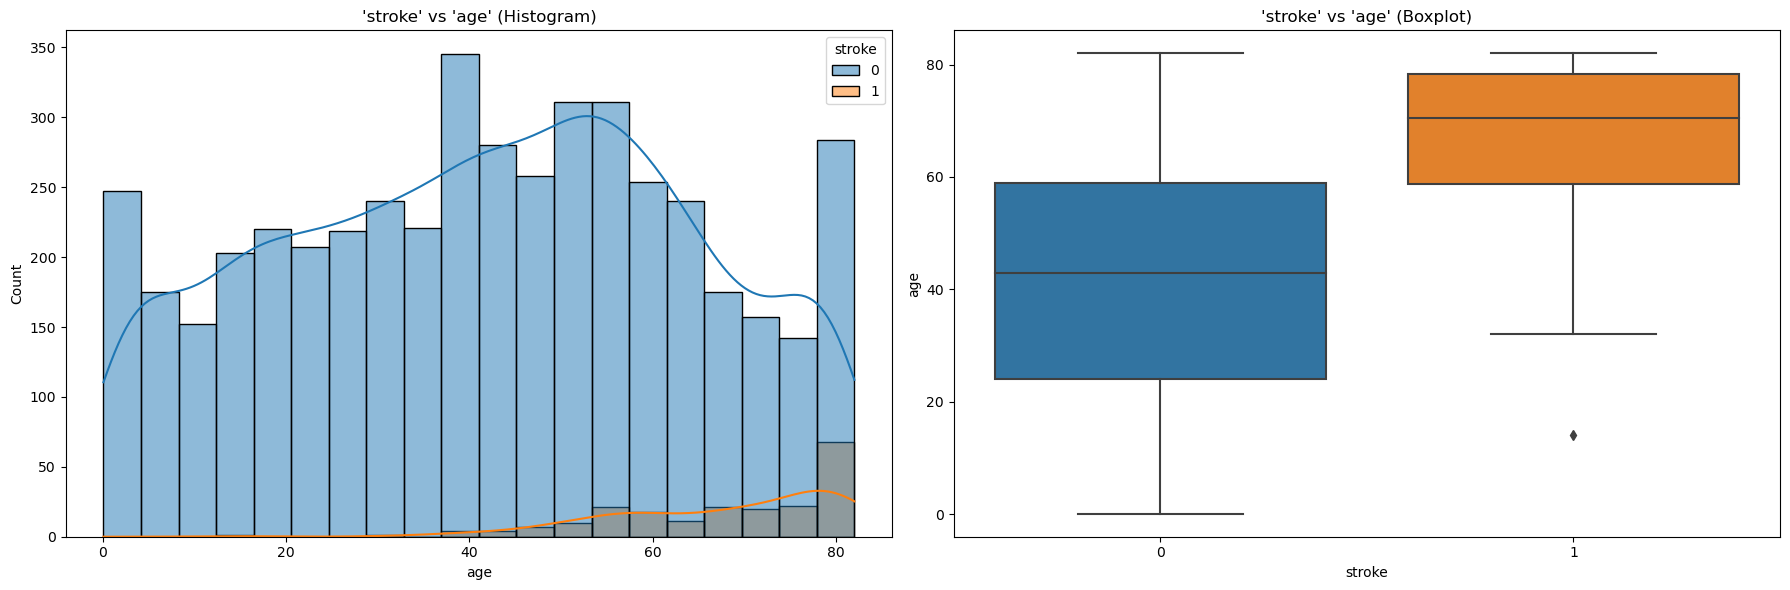

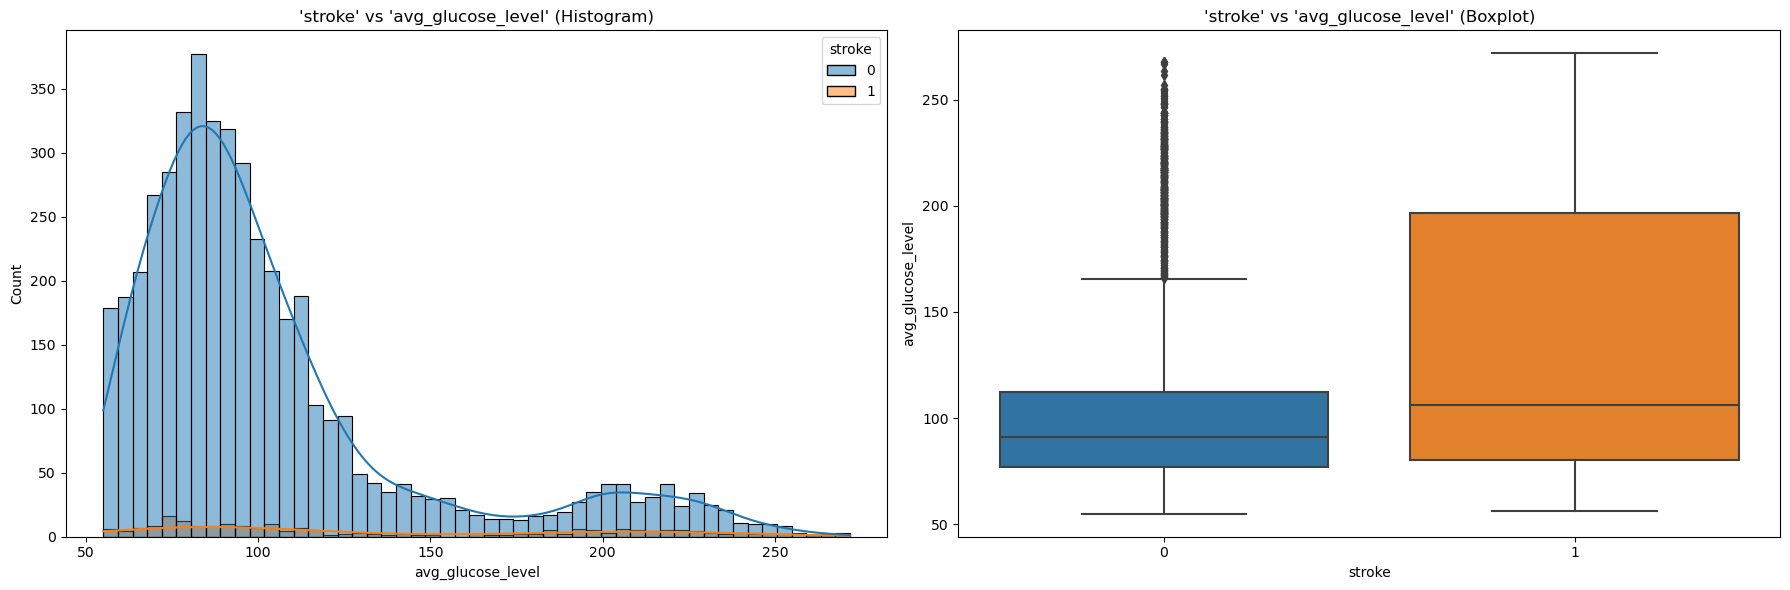

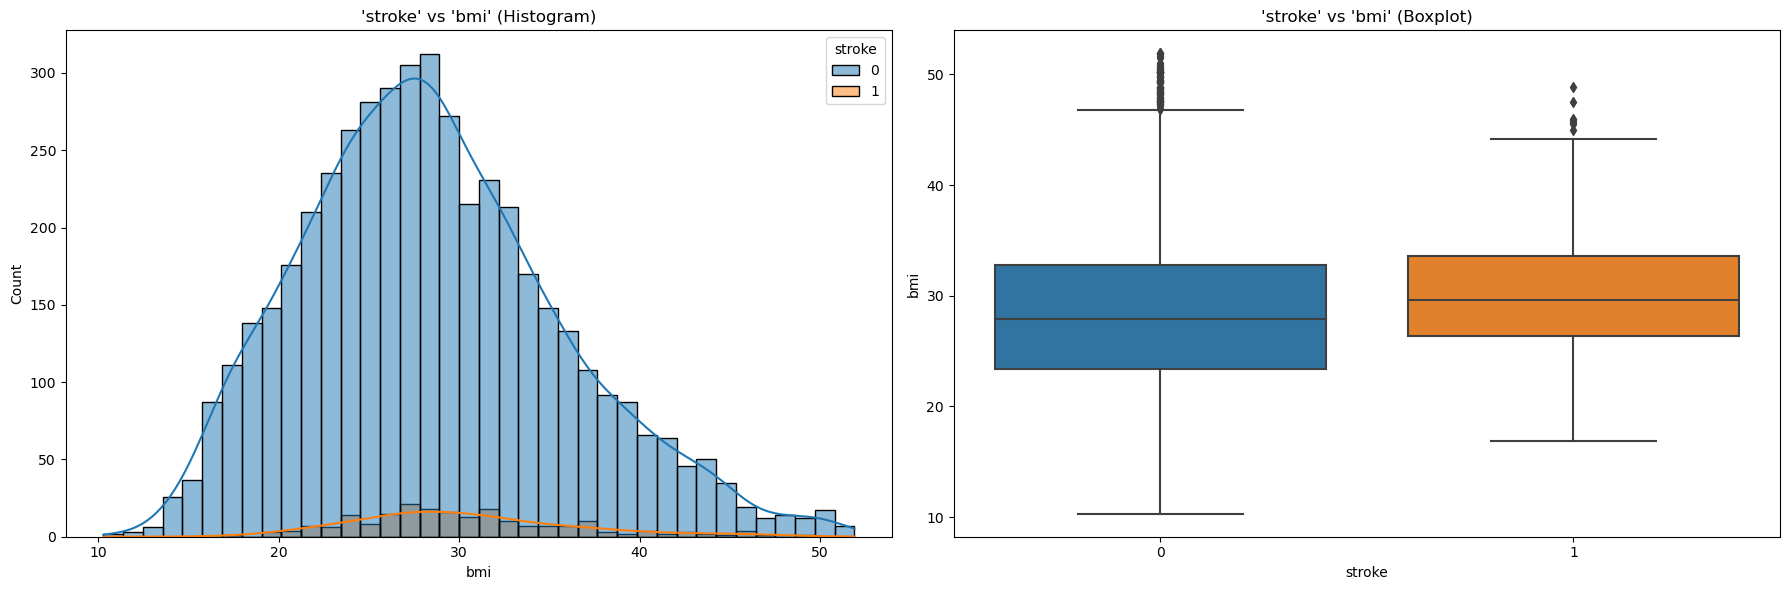

In [28]:
num_cols = ['age', 'avg_glucose_level', 'bmi']
cat_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
generate_plots_and_tables_by_tagret(data_stroke, 'stroke', num_cols, cat_cols)

Widzę pewną zależność pomiędzy:

-nadciśnieniem, a udarami

-chorobami serca a udarami

-wydaje mi się, że proporcja samozatrudnienia a udarów jest wyższa, może to być związane z rodzajem pracy i odpowiedzialności 


# 7. Tworzenie modeli


In [36]:
X, y = data_stroke.drop(columns=['stroke'], axis=1), data_stroke['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

cat_ix = X.select_dtypes(include=['object', 'bool']).columns
num_ix = X.select_dtypes(include=['int64', 'float64']).columns

In [37]:
names = ['CART', 'BAG', 'RF', 'KN', 'LR', 'GBM']
models = [
    DecisionTreeClassifier(),
    BaggingClassifier(n_estimators=100),
    RandomForestClassifier(n_estimators=100),
    KNeighborsClassifier(n_neighbors=3),
    LogisticRegression(),
    GradientBoostingClassifier(n_estimators=100)
]

>CART 0.125 (0.036)
>BAG 0.147 (0.031)
>RF 0.104 (0.043)
>KN 0.116 (0.036)
>LR 0.206 (0.016)
>GBM 0.184 (0.040)


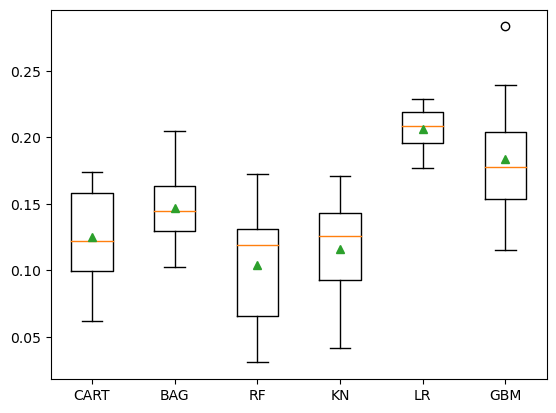

In [38]:
results = list()
for i in range(len(names)):
    transformation_steps = [
        ('c', OneHotEncoder(handle_unknown='ignore'), cat_ix),
        ('n', MinMaxScaler(), num_ix)
    ]
    ct = ColumnTransformer(transformation_steps)
    pipeline = Pipeline(
        steps=[
            ('transform', ct),
            ('smote', SMOTE()),
            ('model', models[i])
        ])
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [41]:
transformation_steps = [
    ('c', OneHotEncoder(handle_unknown='ignore'), cat_ix),
    ('n', MinMaxScaler(), num_ix)
]
ct = ColumnTransformer(transformation_steps)
pipeline = Pipeline(
    steps=[
        ('transform', ct),
        ('smote', SMOTE()),
        ('model', LogisticRegression()) 
    ])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)

grid_search = GridSearchCV(
    estimator=pipeline, cv=cv, scoring="f1_macro"
)
grid_search.fit(X_train, y_train)

TypeError: GridSearchCV.__init__() missing 1 required positional argument: 'param_grid'

In [ ]:
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('ROC AUC score:', roc_auc_score(y_test, y_pred))

WNIOSKI:

  Przy każdym wypróbowanym sposobie wychodzi mi, że moje modelowanie dobrze wyznacza TrueNegativ - czyli, kto nie będzie miał udaru, natomiast bardzo dużo wyznacza FalseNegativ i nie radzi sobie z wyzanczaniem TruePositi - czyli nie rozpoznaje osób z udarem. Czy jest to możliwe, że jest to związane z niezbilansowaną zmienną i niewielką ilością danych Stroke_positiv?
  
  Ale jedna ROC jest wydaje mi się, nie takie niskie (0,73). 
  